# Main Simulation Loop Construction

Develop the main simulation loop for the formation model

01/05/2023

Andrew Weng

In [232]:
import os, sys

# Move the path up a level to be able to index into source files
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

import pandas as pd
import numpy as np
from src import cellsim as cellsim 

%matplotlib widget
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# CV Mode Equations

Current decay during CV mode is analytically solvable for the nRC case:

$$
I_{CV} = \frac{V_t - V_{OC} - \sum_n R_{1,n}I_{R_{1,n}}\exp{(-\frac{\Delta t}{\tau_n})}}{\sum_n(R_{0,n} + R_{1,n}(1-\exp{(-\frac{\Delta t}{\tau_n})}))}
$$

# SEI growth dynamics

SEI growth is modeled using the following approach.

The total applied current is distributed across intercalation and SEI

$$
I_{app} = I_{int} + I_{SEI}
$$

The SEI current is related to the current density by (Eqn. 1j from Sulzer2021):

$$
I_{SEI} = -a_sA_nL_n j_{SEI}
$$

where 
- $a_s$ is the specific surface area [1/m]
- $A_n$ is the negative electrode area [m^2] 
- $L_n$ is the negative electrode length [m] 
- $j_{SEI}$ is the SEI volumetric current density [A/m^3].

The mixed reaction and diffusion limited SEI current density is (Eqn. 16 from Sulzer2021):

$$
j_{SEI} = \frac{-c_{EC}^{bulk}}{1/(a_{sei}Fk_{SEI}\exp(-\alpha_{SEI}F\eta_{SEI}/RT)) + \delta_{SEI}/(D_{SEI}F)}
$$

Note that $j_{SEI} = f(\eta_{SEI}, \delta_{SEI})$. All the other terms in the equation are constants.

The SEI reaction overpotential $\eta_{SEI}$ is (Eqn. 1g from Sulzer2021):

$$
\eta_{SEI} = \phi_{s,n} - \phi_e - U_{SEI} - j_{tot,k}R_{film}\delta_{SEI}
$$

But we also know from Equation [1f] that

$$
\eta_{n} = \phi_{s,n} - \phi_e - U_n(c_{s,n}^{surf}) - j_{tot,n}R_{film}\delta_{SEI}
$$

which can be used to eliminate some variables and re-express the SEI overpotential as

$$
\eta_{SEI} = \eta_n + U_n(c_{s,n}^{surf}) - U_{SEI}
$$




# Modeling expansion

We consider three sources of microscopic expansion:
1. $\delta_p(y)$ : Reversible expansion of the cathode due to lithiation/delithiation
2. $\delta_n(x)$ : Reversible expansion of the anode due to lithiation/delithiation
3. $\delta_{sei}$ : Irreversible expansion of the SEI film on the anode

$\delta_p(y)$ and $\delta_n(x)$ are assumed to remain constant over life.

$\delta_{sei}$ is due to SEI growth and is modeled as (Sulzer2021, eqn. 1h):

$$
\frac{d\delta_{SEI}}{dt} = \bar{V}_{SEI} \frac{j_{SEI}}{2F}
$$

Note the difference in units. $\delta_p$ and $\delta_n$ are numbers between 0 and 1, according to [1]. However, $\delta_{SEI}$ is in units of meters. 

[TODO: make the units more consistent.]

The microscopic expansion terms are related to the macroscopic expanion by:
$$
\epsilon_{tot} = c_0 \delta_{sei} + c_1 \delta_p(y) + c_2 \delta_n(x)
$$
where $c_0$, $c_1$, $c_2$, are coefficients. 

[TODO: these coefficients need some more physical parameterizations to make them relatable to the electrode properties like $a_s$, $R_n$, $R_p$, $A$, $L$, etc.]



[1] Mohtat et al. 2020. “Differential Expansion and Voltage Model for
    Li-Ion Batteries at Practical Charging Rates.” Journal of the
    Electrochemical Society 167 (11): 110561.



Simulating Cycle 1...
Switching from CC charge to CV charge...
Switching from CV charge to CC discharge...
Simulating Cycle 2...
Switching from CC charge to CV charge...
Switching from CV charge to CC discharge...
Simulating Cycle 3...
Switching from CC charge to CV charge...
Switching from CV charge to CC discharge...
Simulating Cycle 4...
Done.


/Users/aweng/code/formation-modeling/src/cellsim.py:289: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/Users/aweng/code/formation-modeling/venv/lib/python3.8/site-packages/ipympl/backend_nbagg.py:336: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.figure.savefig(buf, format='png', dpi='figure')


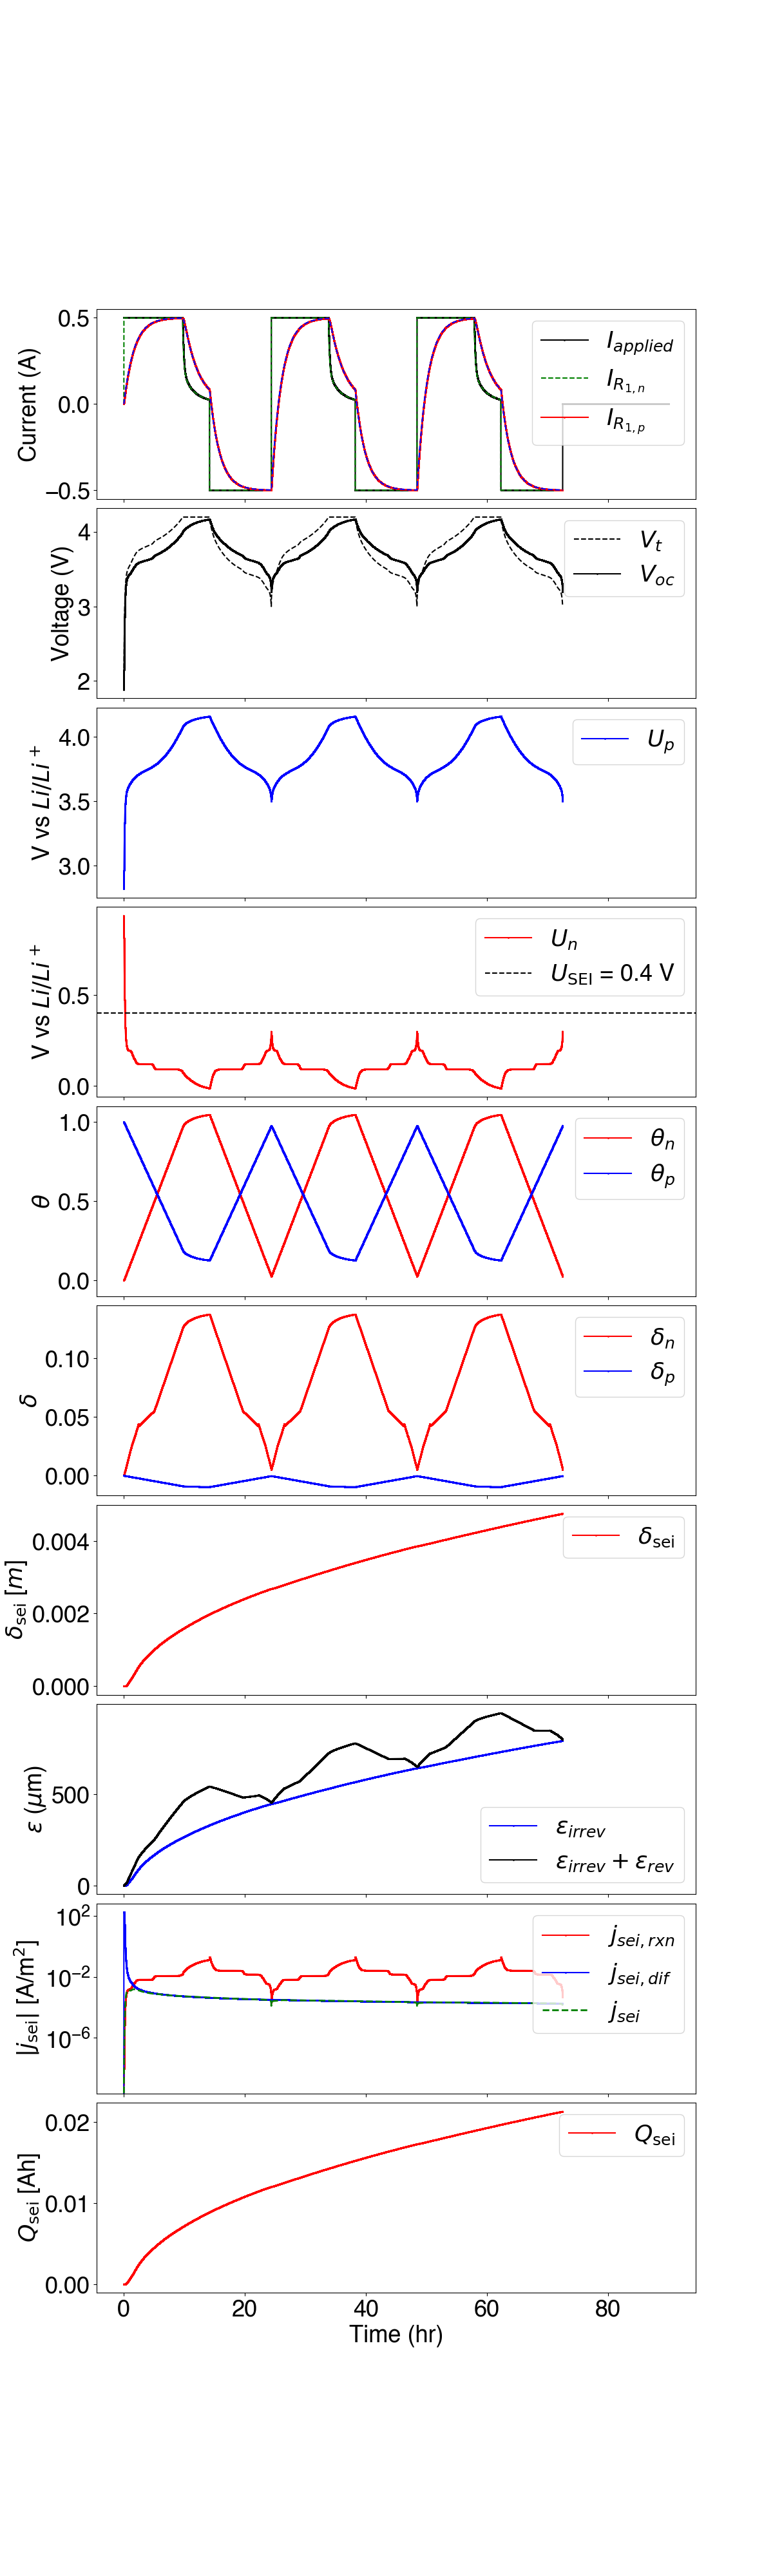

In [235]:
%autoreload

chg_current_amps = +0.5
dch_current_amps = -0.5
current_cv_cut_amps = 0.5 / 20
sim_time_s = 90*3600

cell = cellsim.Cell()
sim = cellsim.Simulation(cell, sim_time_s)

mode = 'cc_charge'
cycle_number = 1

print(f'Simulating Cycle {cycle_number}...')

for k in range(0, len(sim.t) - 1):

    if cycle_number > 3:
        break

    if mode == 'cc_charge':

        sim.step(k, 'cc', icc=chg_current_amps, cyc_num=cycle_number,
                 step_num=0) 

        # Check for constant voltage condition
        if sim.vt[k+1] >= sim.vmax:
            print('Switching from CC charge to CV charge...')
            mode = 'cv_charge'
            sim.vt[k+1] = sim.vmax
            continue
        
    elif mode == 'cv_charge':

        sim.step(k, 'cv', icv=current_cv_cut_amps, cyc_num=cycle_number,
                 step_num=1)

        if np.abs( sim.i_app[k] ) < np.abs( current_cv_cut_amps ):
            print('Switching from CV charge to CC discharge...')
            mode = 'cc_discharge'
            continue

    elif mode == 'cc_discharge':

        sim.step(k, 'cc', icc=dch_current_amps, cyc_num=cycle_number,
                 step_num=2)
        
        if sim.vt[k+1] <= sim.vmin: 
           mode = 'cc_charge'
           cycle_number += 1
           print(f'Simulating Cycle {cycle_number}...')
           continue

print('Done.')


# Make the plot

In [237]:
%autoreload
sim.plot()

/Users/aweng/code/formation-modeling/src/cellsim.py:289: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/Users/aweng/code/formation-modeling/venv/lib/python3.8/site-packages/ipympl/backend_nbagg.py:336: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.figure.savefig(buf, format='png', dpi='figure')


# Calculate cycle-by-cycle metrics

In [236]:
df = pd.DataFrame(sim.__dict__)
df['dq'] = np.abs(df['dt'] * df['i_app'] / 3600)
df_agg = df.groupby(['cycle_number', 'step_number'])['dq'].agg('sum')
df_agg

cycle_number  step_number
0.0           0.0            0.000000
1.0           0.0            4.854722
              1.0            0.392973
              2.0            5.105417
2.0           0.0            4.721806
              1.0            0.389715
              2.0            5.106250
3.0           0.0            4.721111
              1.0            0.389492
              2.0            5.106667
Name: dq, dtype: float64